In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import random
from zipfile import ZipFile
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.metrics import Precision,Recall
from sklearn.metrics import accuracy_score,precision_score,classification_report,f1_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with ZipFile('/content/drive/MyDrive/Colab Notebooks/MangoLeaf.zip', 'r') as zipObj:
   zipObj.extractall()

In [4]:
!pip install split_folders

In [5]:
import splitfolders

os.chdir('/content/MangoLeaf')

#input = where dataset is present
#output = where you want the split datasets saved.

splitfolders.ratio("/content/MangoLeaf", output="/content/Output", seed=1337, ratio=(.75, .1, .15))

# ratio of split are in order of train/val/test.

os.chdir('../../')

Copying files: 1014 files [00:00, 7274.22 files/s]


In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/Output/train'
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   class_mode = 'categorical',
                                                   target_size = (224,224),
                                                   batch_size = 10)

validation_dir = '/content/Output/val'
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                             class_mode = 'categorical',
                                                             target_size = (224,224),
                                                             batch_size = 10)

test_dir = '/content/Output/test'
test_generator = test_datagen.flow_from_directory(test_dir,
                                                             class_mode = 'categorical',
                                                             target_size = (224,224),
                                                             batch_size = 10)

Found 760 images belonging to 4 classes.
Found 100 images belonging to 4 classes.
Found 154 images belonging to 4 classes.


In [7]:
pre_trained_model = ResNet50V2(input_shape=(224,224,3),include_top=False,weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
pre_trained_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [9]:
last_layer = pre_trained_model.get_layer('post_relu')
last_output = last_layer.output
print(last_output)

<KerasTensor shape=(None, 7, 7, 2048), dtype=float32, sparse=False, name=keras_tensor_189>


In [10]:
x = Flatten()(last_output)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(4,activation = 'softmax')(x)

metrics = ['accuracy',tf.keras.metrics.Precision()]
model = Model(pre_trained_model.input,x)
model.compile(optimizer = Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=metrics)

In [11]:
x = pre_trained_model.output
x = GlobalAveragePooling2D()(x)  # Replace Flatten() with GAP to reduce overfitting
x = Dense(4096, activation='relu')(x)
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
output_layer = Dense(12, activation='softmax')

In [12]:
model.summary();

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 126,330,372 (481.91 MB)

 Trainable params: 102,765,572 (392.02 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
history = model.fit(train_generator,epochs=2,validation_data=validation_generator,batch_size=64)

Epoch 1/2
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 98ms/step - accuracy: 0.6655 - loss: 3.3649 - precision: 0.6708 - val_accuracy: 0.8300 - val_loss: 1.8145 - val_precision: 0.8300
Epoch 2/2
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8375 - loss: 1.8089 - precision: 0.8375 - val_accuracy: 0.8000 - val_loss: 2.3409 - val_precision: 0.8081


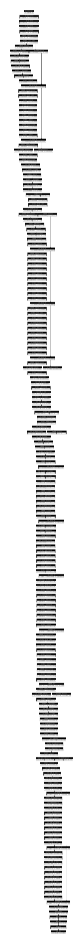

In [15]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import IPython.display as display

# Plot the model architecture
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

# Display the plot in Jupyter Notebook
image = plt.imread("model_plot.png")
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis("off")
plt.show()

In [16]:
import os

true_labels = []

# Iterate directly through the test directory structure
for category in os.listdir('/content/Output/test'):
    category_path = os.path.join('/content/Output/test', category)

    # Check if it's a directory (to avoid files)
    if os.path.isdir(category_path):
        # Get the class label based on the directory name
        if category == "1Partially Infected":
            label = 0
        elif category == "2Quaterly":
            label = 1
        elif category == "3Fully infected":
            label = 2
        elif category == "4Healthy":
            label = 3
        else:
            # Handle unknown categories if needed
            label = -1  # Or raise an exception

        # Add labels for each image in the category
        true_labels.extend([label] * len(os.listdir(category_path)))

In [17]:
print(true_labels)
print(len(true_labels))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
154


In [18]:
from tensorflow.keras.preprocessing import image # Import the image module from keras.preprocessing
def calculate_test_preds(source, model):
    predictions = []
    print(f"Scanning directory: {source}")

    # Loop through each subdirectory (category)
    for category in os.listdir(source):
        category_path = os.path.join(source, category)

        # Check if it is a directory (to avoid errors from files)
        if os.path.isdir(category_path):
            print(f"Processing category: {category}")

            # Loop through each image file in the subdirectory
            for imgname in os.listdir(category_path):
                img_path = os.path.join(category_path, imgname)

                # Load and preprocess the image
                img = image.load_img(img_path, target_size=(224, 224))
                x = image.img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = x / 255.0  # Normalize

                # Predict using the model
                pred = model.predict(x)
                pred = np.argmax(pred)  # Get class index
                predictions.append(pred)

    return predictions

In [19]:
for imgname in os.listdir('/content/Output/test'):
  img_path = os.path.join("/content/Output/Test",imgname)
  print(imgname)

2Quaterly
1Partially Infected
3Fully infected
4Healthy


In [20]:
predictions = calculate_test_preds("/content/Output/test",model)

Scanning directory: /content/Output/test
Processing category: 2Quaterly
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━

In [21]:
accuracy_score(true_labels,predictions)

0.7857142857142857

In [22]:
cm=confusion_matrix(true_labels,predictions)
print(cm)

[[48  3  0  1]
 [ 5 36  9  0]
 [ 1 12  9  0]
 [ 2  0  0 28]]


In [23]:
print(classification_report(true_labels,predictions))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89        52
           1       0.71      0.72      0.71        50
           2       0.50      0.41      0.45        22
           3       0.97      0.93      0.95        30

    accuracy                           0.79       154
   macro avg       0.76      0.75      0.75       154
weighted avg       0.78      0.79      0.78       154



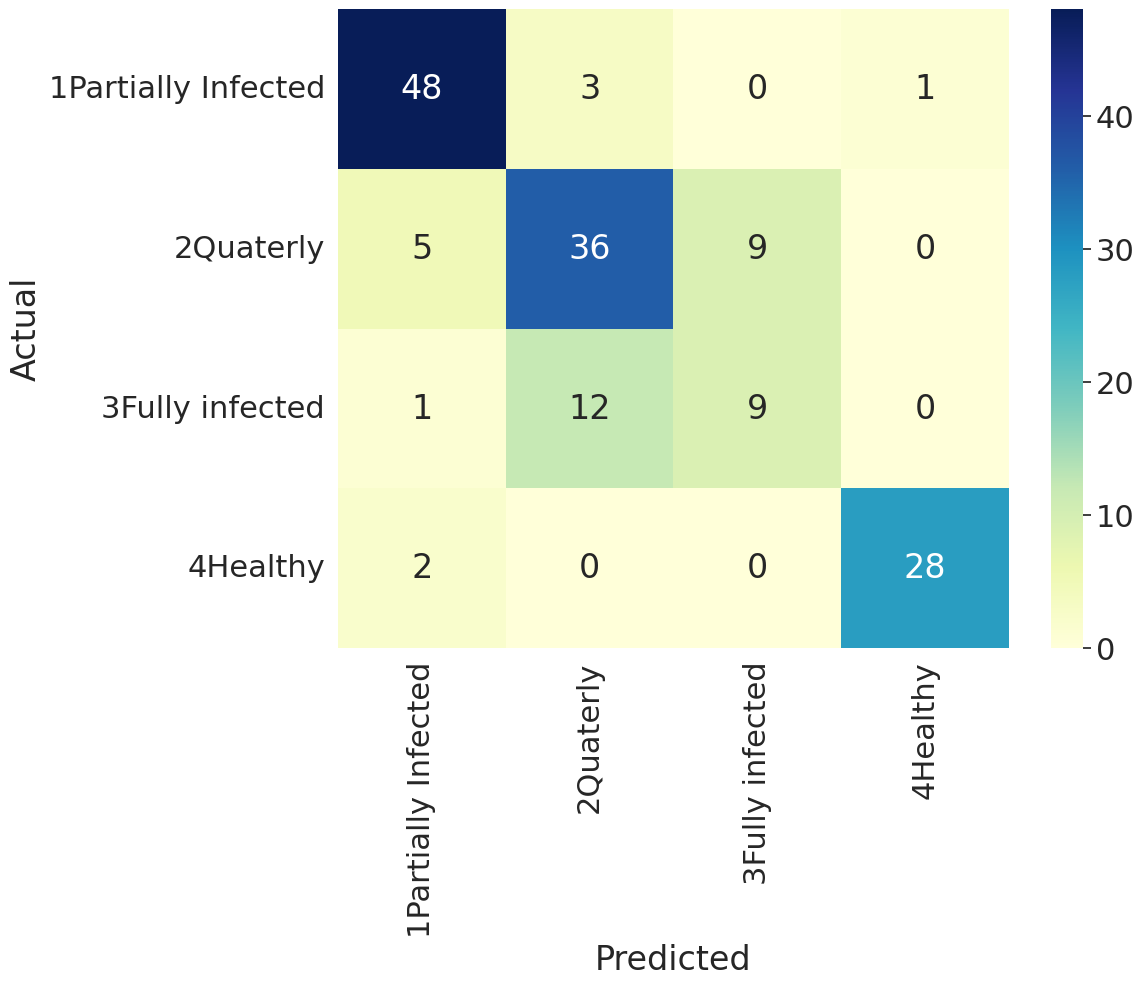

In [24]:
import seaborn
import numpy as np
seaborn.set(font_scale=2)
fig, ax = plt.subplots(figsize=(12,10))
classes = true_labels
# Define class_names to match the order of your labels
class_names = ["1Partially Infected", "2Quaterly", "3Fully infected", "4Healthy"]
seaborn.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names,cmap='YlGnBu')
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
plt.tight_layout()   #automatically adjusts subplot params
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()